## 02807 Computational Tools for Data Science
### Final project - Counter Strike e-Sport data analysis 

Counter-Strike Global Offensive is a game released in 2012, as a sequel to Counter-Strike Source (released in 2004), which is itself a sequel to the original Counter-Strike (released in 2000). The game's longevity is primarily caused by its competitive approach and vibrant professional scene. This longevity has shown in numbers recently, as CS:GO reached in March its all-time high concurrent players (1.1M players), making it the most played game on Steam, 7 years after it was launched. So, I thought it would be interesting to celebrate this milestone by grouping relevant data about the game and seeing what insights people can get from it!

https://www.kaggle.com/datasets/mateusdmachado/csgo-professional-matches/data

In [32]:
#Import Section
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,DBSCAN
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.use("TkAgg")

In [2]:
filepath_player = "data/players.csv"
filepath_match = "data/results.csv"
filepath_picks = "data/picks.csv"
filepath_eco = "data/economy.csv"

df_player = pd.read_csv(filepath_player)
df_match = pd.read_csv(filepath_match)
df_picks = pd.read_csv(filepath_picks)
df_eco = pd.read_csv(filepath_eco, dtype='unicode')

print("DataFrame loaded")

DataFrame loaded


Economy Dataset:

This dataset has 43,234 rows and 99 columns.
Columns include date, match_id, event_id, teams, map, starting sides, and detailed round-by-round economy data for each team (e.g., 1_t1, 2_t1, etc. up to 30 rounds).

Players Dataset:

This dataset wasn't displayed due to its size. I'll provide a detailed analysis of its contents in a separate step.

Results Dataset:

Contains 45,773 rows and 19 columns.
Columns cover details like date, team names, map, round results, map winner, starting side, event ID, match ID, team ranks, map wins, and the match winner.

Picks Dataset:

Comprises 16,035 rows and 17 columns.
Columns include date, team names, match_id, event_id, best of series info, system, maps removed and picked by each team, and the leftover map.

In [3]:
df_player.head()

,date,player_name,team,opponent,country,player_id,match_id,event_id,event_name,best_of,...,m3_kddiff_ct,m3_adr_ct,m3_kast_ct,m3_rating_ct,m3_kills_t,m3_deaths_t,m3_kddiff_t,m3_adr_t,m3_kast_t,m3_rating_t
0,2020-02-26,Brehze,Evil Geniuses,Liquid,United States,9136,2339385,4901,IEM Katowice 2020,3,...,-1.0,72.5,80.0,0.93,7.0,9.0,-2.0,70.4,63.6,0.89
1,2020-02-26,CeRq,Evil Geniuses,Liquid,Bulgaria,11219,2339385,4901,IEM Katowice 2020,3,...,3.0,79.5,53.3,1.12,4.0,8.0,-4.0,40.7,54.5,0.53
2,2020-02-26,EliGE,Liquid,Evil Geniuses,United States,8738,2339385,4901,IEM Katowice 2020,3,...,1.0,81.5,63.6,1.03,9.0,9.0,0.0,87.9,73.3,1.05
3,2020-02-26,Ethan,Evil Geniuses,Liquid,United States,10671,2339385,4901,IEM Katowice 2020,3,...,0.0,67.2,66.7,0.97,1.0,9.0,-8.0,14.8,45.5,0.31
4,2020-02-26,NAF,Liquid,Evil Geniuses,Canada,8520,2339385,4901,IEM Katowice 2020,3,...,-1.0,72.9,81.8,0.96,8.0,7.0,1.0,56.3,80.0,0.99


In [4]:
df_match.head()

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2
1,2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2
2,2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2
3,2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2
4,2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2


In [5]:
df_picks.head()

,date,team_1,team_2,inverted_teams,match_id,event_id,best_of,system,t1_removed_1,t1_removed_2,t1_removed_3,t2_removed_1,t2_removed_2,t2_removed_3,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,1,2340454,5151,3,123412,Vertigo,Train,0.0,Nuke,Overpass,0.0,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,0,2340453,5151,3,123412,Dust2,Nuke,0.0,Mirage,Train,0.0,Vertigo,Inferno,Overpass
2,2020-03-18,New England Whalers,Station7,0,2340461,5243,1,121212,Mirage,Dust2,Vertigo,Nuke,Train,Overpass,0.0,0.0,Inferno
3,2020-03-17,Complexity,forZe,1,2340279,5226,3,123412,Inferno,Nuke,0.0,Overpass,Vertigo,0.0,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,0,2340456,5247,3,123412,Train,Mirage,0.0,Nuke,Inferno,0.0,Overpass,Vertigo,Dust2


In [6]:
df_eco.head()

,date,match_id,event_id,team_1,team_2,best_of,_map,t1_start,t2_start,1_t1,...,21_winner,22_winner,23_winner,24_winner,25_winner,26_winner,27_winner,28_winner,29_winner,30_winner
0,2020-03-01,2339402,4901,G2,Natus Vincere,5,Nuke,t,ct,4350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-01,2339402,4901,G2,Natus Vincere,5,Dust2,ct,t,3900.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN
2,2020-03-01,2339402,4901,G2,Natus Vincere,5,Mirage,t,ct,4150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Dust2,t,ct,4150.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Nuke,ct,t,4200.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1 Team Win retes
Conducts a year-by-year analysis of CS:GO teams' win rates, focusing on those teams that were active throughout the years 2015 to 2020. The final visualization provides an easy-to-understand representation of these trends.

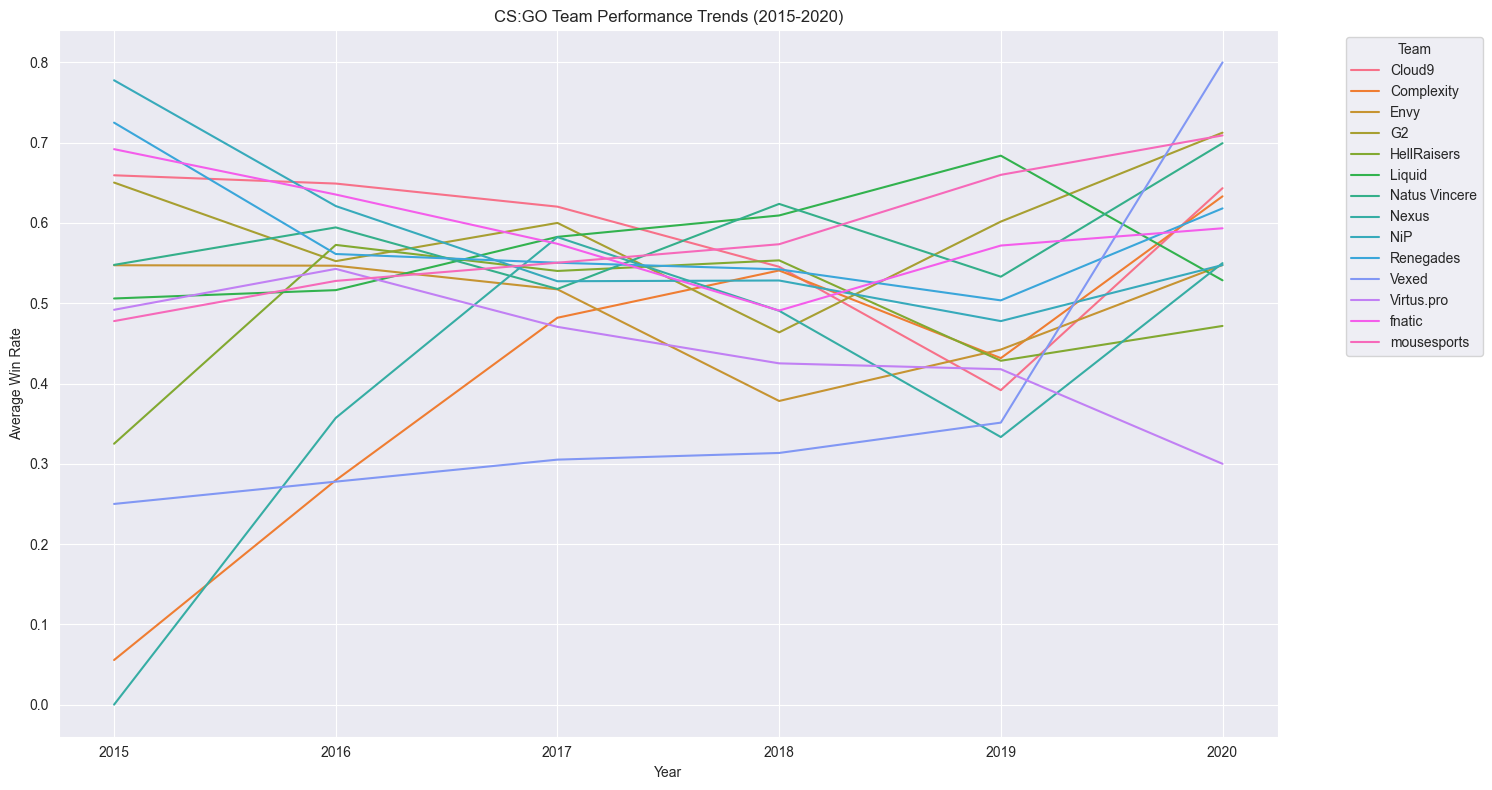

In [7]:
# Convert date to datetime
df_match['date'] = pd.to_datetime(df_match['date'])

# Prepare dataset for team performance analysis
team_performance_df = df_match[['date', 'team_1', 'team_2', 'map_winner', 'event_id', 'match_id']].copy()
team_performance_df['team_1_win'] = team_performance_df['map_winner'] == 1
team_performance_df['team_2_win'] = team_performance_df['map_winner'] == 2
team_performance_df['year'] = team_performance_df['date'].dt.year

# Calculate win rates for each team
team_1_yearly = team_performance_df.groupby(['year', 'team_1']).team_1_win.mean().reset_index()
team_2_yearly = team_performance_df.groupby(['year', 'team_2']).team_2_win.mean().reset_index()
team_1_yearly.rename(columns={'team_1': 'team', 'team_1_win': 'win_rate'}, inplace=True)
team_2_yearly.rename(columns={'team_2': 'team', 'team_2_win': 'win_rate'}, inplace=True)
combined_team_performance = pd.concat([team_1_yearly, team_2_yearly])
average_team_performance = combined_team_performance.groupby(['year', 'team']).win_rate.mean().reset_index()

# Filter teams active from 2015 to 2020
years = list(range(2015, 2021))
teams_active_all_years = average_team_performance.groupby('team').filter(lambda x: all(y in x['year'].values for y in years))

# Plotting the results
plt.figure(figsize=(15, 8))
sns.lineplot(data=teams_active_all_years, x='year', y='win_rate', hue='team')
plt.title('CS:GO Team Performance Trends (2015-2020)')
plt.xlabel('Year')
plt.ylabel('Average Win Rate')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
unique_player_names = df_player['player_name'].unique()
unique_player_names

array(['Brehze', 'CeRq', 'EliGE', ..., 'ampen', 'skippii', 'Vulmest'],
      dtype=object)

## 2Frequent Itemsets:Player combinations

Haocheng

Identify common player combinations in winning teams. If certain players often appear together in winning matches, it might indicate strong team synergy.
Analyze frequent map choices in combination with winning teams to see if certain teams have a preference or better performance on specific maps.



方法
将频繁项集的概念应用于 CS:GO 数据集来识别获胜团队中的常见玩家组合并分析频繁的地图选择可能非常有洞察力。方法如下：

识别获胜球队中的常见球员组合：

数据准备：从球员数据集中提取与获胜球队相关的数据。这通常涉及过滤数据集以查找特定球队获胜的比赛，并记录参加这些比赛的球员。
频繁项集挖掘：使用 Apriori 或 FP-Growth 等算法，识别在这些获胜比赛中经常一起出现的玩家集。这些集合或项目集代表经常一起参与成功游戏的玩家的组合。
分析解读：频繁的球员组合可以洞察球队的协同作用。如果某些球员在一起比赛时始终能够赢得比赛，这可能表明他们有很强的团队合作精神或互补的技能。
与获胜团队分析常见的地图选择：

数据准备：使用结果数据集将地图选择与比赛结果相关联。您需要确定比赛中进行了哪些地图以及哪支球队赢得了这些比赛。
频繁项集挖掘：应用类似的频繁项集挖掘过程来发现通常会带来胜利的地图和团队的组合。此分析将有助于确定某些团队是否在特定地图上表现更好。
分析和解释：结果可以让我们了解队伍是否对某些地图有偏好，或者他们在特定地图上是否有更高的胜率。这对于锦标赛中的战略规划以及了解特定于地图的技能或团队策略非常有用。
频繁项集挖掘的一般步骤：

选择算法：选择 Apriori 等算法，它非常适合查找频繁项集。Apriori 因其处理大型数据集的简单性和效率而成为流行的选择。
设置支持阈值：确定最小支持阈值，这是项目集被视为重要的最小频率。
运行算法：将算法应用于准备好的数据集，以识别满足或超过支持阈值的项集。
解释结果：分析已识别的项目集以得出结论并获得与游戏策略和团队绩效相关的见解。

In [9]:
player_stats = df_player.groupby('player_name').agg({'rating': 'mean', 'match_id': 'count'})

# Filter players who have played more than 20 matches
players_over_matches = player_stats[player_stats['match_id'] > 50]

# Sort by average rating and get the top 10 players
top_10_players = players_over_matches.sort_values(by='rating', ascending=False).head(10)
top_10_players

,rating,match_id
player_name,,
ZywOo,1.395688,327
HuNtR,1.314107,56
XANTARES,1.309018,550
Sico,1.296490,396
vsm,1.295930,172
s1mple,1.293876,485
blameF,1.278400,200
sh1ro,1.276142,127
BnTeT,1.275696,388


In [10]:
# Create a new column for the winning team's name
df_match['winning_team'] = df_match.apply(
    lambda row: row['team_1'] if row['match_winner'] == 1 else row['team_2'], 
    axis=1
)

# Select only the match_id and winning_team columns
winning_teams_df = df_match[['match_id', 'winning_team']]

# Drop duplicates to ensure match_id is unique
winning_teams_df= winning_teams_df.drop_duplicates(subset=['match_id'])
 
winning_teams_df

,match_id,winning_team
0,2340454,TeamOne
2,2340461,Station7
3,2340453,Bad News Bears
5,2340456,Endpoint
7,2340455,Espada
...,...,...
45765,2299057,Vexed
45767,2299059,E-frag.net
45770,2299011,CLG
45771,2299001,NiP


In [11]:
merged_df

NameError: name 'merged_df' is not defined

In [ ]:
# Merge player and match data
merged_df = pd.merge(df_player, winning_teams_df, on='match_id')


# Calculate win counts for each player
player_win_counts = merged_df['player_name'].value_counts()

# Create a list of players who have more than 10 wins
players_with_more_than_10_wins = player_win_counts[player_win_counts > 10].index.tolist()

# Filter the DataFrame for these players
filtered_winning_teams_df = merged_df[merged_df['player_name'].isin(players_with_more_than_10_wins)]

filtered_winning_teams_df

In [ ]:
baskets = []
for match_id, group in filtered_winning_teams_df.groupby('match_id'):
    # Filter to keep only players from the winning team
    winning_team_players = group[group['team'] == group['winning_team']]['player_name']
    # Create a basket (set) of unique player names
    basket = list(set(winning_team_players))
    baskets.append(basket)
len(baskets)

In [ ]:
# Ensure all player names are treated as strings and drop any NaN values
filtered_winning_teams_df['player_name'] = filtered_winning_teams_df['player_name'].astype(str).copy()
filtered_winning_teams_df = filtered_winning_teams_df.dropna(subset=['player_name'])

# Extract and sort unique player names
all_players = sorted(filtered_winning_teams_df['player_name'].unique())
len(all_players)
#all_players

In [ ]:
df_players_hash = pd.DataFrame(range(len(all_players)), index = list(all_players), columns =['hashcode'], dtype=int)
df_players_hash

In [ ]:
item_count_arr = np.zeros((len(all_players),1))

for b in baskets:
    for item in b:
            idx = df_players_hash.loc[item,'hashcode']
            item_count_arr[idx] += 1
            
### find frequent items with support > s1 (here s1 = 0.02), and hash back from array index to items           
freq_items  = [df_item_hash[df_item_hash['hashcode']==x].index[0] for x in np.where(item_count_arr > 0.2*len(baskets))[0]] 
freq_items

## 3 Huiyu Xie

In [3]:
player_kills = df_player.groupby("player_name")[["kills","assists","deaths","hs","flash_assists","rating"]].mean().apply(lambda x: x)
player_count = df_player.value_counts()
player_kills.dropna()
player_kills.fillna(0, inplace=True)
player_kills

,kills,assists,deaths,hs,flash_assists,rating
player_name,,,,,,
!99,6.500000,2.000000,18.000000,2.500000,0.000000,0.390000
$ally,42.000000,8.000000,37.500000,18.000000,0.000000,1.110000
$h0cK3r,20.000000,1.000000,34.000000,11.000000,1.000000,0.640000
-AtomiK,10.000000,2.000000,17.666667,4.666667,0.000000,0.630000
-Backstab,13.500000,3.000000,27.500000,8.000000,0.000000,0.570000
...,...,...,...,...,...,...
zyoutan,16.000000,4.000000,34.000000,5.000000,0.000000,0.510000
zyp,31.206897,7.172414,36.482759,16.310345,1.392857,0.928276
zypath,35.285714,10.571429,38.714286,9.000000,3.333333,0.922857


In [4]:
kda = player_kills
kda["deaths"] = kda["deaths"].replace(0,1)
player_kills["kda"] = (kda['kills']+kda["assists"]) / kda["deaths"]
player_kills

,kills,assists,deaths,hs,flash_assists,rating,kda
player_name,,,,,,,
!99,6.500000,2.000000,18.000000,2.500000,0.000000,0.390000,0.472222
$ally,42.000000,8.000000,37.500000,18.000000,0.000000,1.110000,1.333333
$h0cK3r,20.000000,1.000000,34.000000,11.000000,1.000000,0.640000,0.617647
-AtomiK,10.000000,2.000000,17.666667,4.666667,0.000000,0.630000,0.679245
-Backstab,13.500000,3.000000,27.500000,8.000000,0.000000,0.570000,0.600000
...,...,...,...,...,...,...,...
zyoutan,16.000000,4.000000,34.000000,5.000000,0.000000,0.510000,0.588235
zyp,31.206897,7.172414,36.482759,16.310345,1.392857,0.928276,1.051985
zypath,35.285714,10.571429,38.714286,9.000000,3.333333,0.922857,1.184502


In [44]:
X = player_kills[["kda","hs","rating"]]
scale = StandardScaler()
x_scale = scale.fit_transform(X)
inertia_values = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scale)
    inertia_values.append(kmeans.inertia_)
# kmeans = KMeans(n_clusters=k,random_state=69)
# player_kills["cluster"] = kmeans.fit_predict(x_scale)
plt.plot(range(2, 10), inertia_values, marker='o')
plt.draw()
plt.pause(10)
plt.close()

In [45]:
k = 2
kmeans = KMeans(n_clusters=k,random_state=69)
player_kills["cluster"] = kmeans.fit_predict(x_scale)

In [56]:
%matplotlib widget
import matplotlib
matplotlib.use("TkAgg")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(k):
    cluster_points = player_kills[player_kills['cluster'] == cluster]
    ax.scatter(cluster_points["kda"], cluster_points["hs"], cluster_points["rating"], label=f'Cluster {cluster}')

ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
           marker='.', s=200, color='red', label='K-Means Center')

ax.set_title('K-means Clustering of Player Performance')
ax.set_xlabel('K/D Ratio')
ax.set_ylabel('Headshot %')
ax.set_zlabel('Rating')

ax.view_init(0, 0)
plt.draw()
plt.pause(60)
plt.close()

In [52]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
player_kills['Cluster'] = dbscan.fit_predict(x_scale)

In [57]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in player_kills['cluster'].unique():
    cluster_points = player_kills[player_kills['cluster'] == cluster]
    ax.scatter(cluster_points['kda'], cluster_points['hs'], cluster_points['rating'], label=f'Cluster {cluster}')

ax.set_xlabel('K/D Ratio')
ax.set_ylabel('Headshot %')
ax.set_zlabel('Rating')
ax.set_title('DBSCAN Clustering of Player Performance')
ax.legend()
plt.draw()
plt.pause(60)
plt.close()

## 4 皇波纹